# Choropleth Maps - Data Classification and Visualization

Author: Fangzheng Lyu

This notebook is related to the paper [Mapping dynamic human sentiments of heat exposure with location-based social media data](https://www.tandfonline.com/doi/full/10.1080/13658816.2024.2343063)

Evaulting and mapping human sentiments of heat exposure.
- Natural Interval
- Qantile Map
- Equal Interval

## Notebook Outline
- [Processing Twitter/X Data](#processing)
- [Understanding How Human Sentiments of Heat Exposure from Tweet Posts](#understand)
- [Aggregate the result to the census tract](#aggregate)
- [Choropleth Map](#map)

In [75]:
## Import Library
import pytz
from datetime import datetime, timedelta
import os
import geopandas as gpd
import json
from shapely.geometry import Polygon, Point, MultiPolygon
import shapefile
import re
import shapefile as shp  # Requires the pyshp package
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
import numpy as np
import random
import csv

<a id='processing'></a>

## 1. Processing Twitter/X Data

The following cell will allow users to extract and filter the social media data Twitter/X.

In [6]:
## Load chicago shapefile
shapefile = gpd.read_file("./geo/geo_export_5bb8636f-65b7-450a-8fd9-7f01027fd84b.shp")
chicago_shape = shapefile["geometry"][0]

Filter all the Twitter/X data by location, find all data within the city of Chicago

In [7]:
## get the twitter in chicago
## City scale analysis
## This block of code will takes a long time
## We iterate through all the twitter collected for find twitter in chicago
## Get the filename
filelist = os.listdir('./data/')[1:]
filelist

twitter_in_chicago = []

# Opening JSON file
for filename in filelist:
    filepath = "./data/"+filename
    print(filepath)
    f = open(filepath)
    data = json.load(f)
    
    ## Read the data if the centroid of the twitter point polygon lies within the boundary of the city of Chicago
    for i in range(0, len(data)):
        try:
            ##Need to deal with case when the shapefile is too big
            text = data[i]["text"]
            t = data[i]['created_at']
            ## Case 1
            ## Twitter with exact geospatial location
            if (data[i]['geo']!=None):
                lat = data[i]['geo']['coordinates'][0]
                lon = data[i]['geo']['coordinates'][1]
                exact_loc = Point(lon, lat)
                if chicago_shape.contains(point):
                    ## print("inside")
                    twitter_in_chicago.append((exact_loc, t, text))
            else:
                ## Twitter with a polygon bounding box
                poly = data[i]['place']['bounding_box']["coordinates"][0]
                lon = -1000
                lat = -1000

                lon = [p[0] for p in poly]
                lat = [p[1] for p in poly]
                centroid = (sum(lon) / len(poly), sum(lat) / len(poly))
                point = Point(centroid)
                ## check if a centroid is in the bounding box of chicago
                if chicago_shape.contains(point):
                    ## print("inside")
                    twitter_in_chicago.append((poly, t, text))
        except:
            ## no geographical location
            pass
    # Closing file
    f.close()

./data/250000-tweets-2021-09-26_01-46-49.json
./data/250000-tweets-2021-09-25_20-12-57.json
./data/250000-tweets-2021-09-26_19-43-23.json
./data/250000-tweets-2021-09-26_22-13-26.json
./data/250000-tweets-2021-09-25_17-48-51.json
./data/250000-tweets-2021-09-26_09-39-36.json
./data/250000-tweets-2021-09-26_07-36-30.json
./data/250000-tweets-2021-09-25_22-39-35.json
./data/250000-tweets-2021-09-25_13-24-18.json
./data/250000-tweets-2021-09-25_01-48-23.json
./data/250000-tweets-2021-09-26_11-29-11.json
./data/250000-tweets-2021-09-26_13-18-44.json
./data/250000-tweets-2021-09-25_09-29-48.json
./data/250000-tweets-2021-09-26_17-16-06.json
./data/250000-tweets-2021-09-26_15-10-52.json
./data/250000-tweets-2021-09-25_11-25-23.json
./data/250000-tweets-2021-09-25_07-33-30.json
./data/250000-tweets-2021-09-25_15-34-24.json
./data/250000-tweets-2021-09-26_04-56-08.json


In [9]:
print ("There are in total "+str(len(twitter_in_chicago))+" geo-tagged Twitter Collected in Chicago in 9/25/2021 & 9/26/2021")

There are in total 22440 geo-tagged Twitter Collected in Chicago in 9/25/2021 & 9/26/2021


In [17]:
## Example of Twitter Message
twitter_in_chicago[3]

([[-87.940033, 41.644102],
  [-87.940033, 42.023067],
  [-87.523993, 42.023067],
  [-87.523993, 41.644102]],
 'Sun Sep 26 03:39:53 +0000 2021',
 'Double Hennessy and pineapple juice for the drink okay')

<a id='understand'></a>

## 2. Understanding How Human Sentiments of Heat Exposure from Tweet Posts

The following cell will allow users to apply heat dictionary generated using pretrained NLP model to understand the Twitter post

A keyword-based NLP mehtod is adopted to the generated the heat dictionary. And the heat dictionary is used to access whether each Tweet post is talking about weather and how much is it talking about hot/cold weather.

In [18]:
## Read the word heat dictionary
f = open('./geo/data20000.txt','r')
content = f.read()
f.close()
dict_word = {}
content_list = content.split(",")
for i in range(0,len(content_list)):
    try:
        word = content_list[i].split(":")[0].split("'")[1]
        #print(content_list[i].split(":"))
        val = float(content_list[i].split(":")[1])
        dict_word[word] = val
    except:
        pass

Apply the heat dictionary onto all the Tweets found in the city of Chicago.

In [19]:
## Iterate through all twitter data in chicago

d_twitter = []
for i in range(0, len(twitter_in_chicago)):
    loc = twitter_in_chicago[i][0]
    t = twitter_in_chicago[i][1]
    text = twitter_in_chicago[i][2]
    res = re.findall(r'\w+', text.lower())
    val = 0
    for word in res:
        if word in dict_word.keys():
            val = val + dict_word[word]
    ## remove weather-irrelevant twitter
    ## if none of the word in the heat dictionary show up 
    if (val!=0):
        d_twitter.append((loc, t, val))

In [20]:
print("There are "+str(len(d_twitter))+" weather-related Twitter in Chicago")

There are 848 weather-related Twitter in Chicago


In [22]:
m_dic = {}
m_dic['Jan'] = 1
m_dic['Feb'] = 2
m_dic['Mar'] = 3
m_dic['Apr'] = 4
m_dic['May'] = 5
m_dic['Jun'] = 6
m_dic['Jul'] = 7
m_dic['Aug'] = 8
m_dic['Sep'] = 9
m_dic['Oct'] = 10
m_dic['Nov'] = 11
m_dic['Dec'] = 12

In [120]:
## Find the time difference between the current time and the Twitter post time
today = datetime(2021,9, 25, 0)
weather_related_twitter = []
sec = []
for twitter in d_twitter:
    loc = twitter[0]
    t = twitter[1].split()
    val = twitter[2]
    month = m_dic[t[1]]
    day = int(t[2])
    year = int(t[5])
    hour = int(t[3].split(":")[0])
    minute = int(t[3].split(":")[1])
    twitter_t = datetime(year, month, day, hour, minute)
    diff_minute = abs(twitter_t - today).total_seconds() / 60.0
    weather_related_twitter.append((loc, diff_minute, val))
    sec.append(diff_minute)

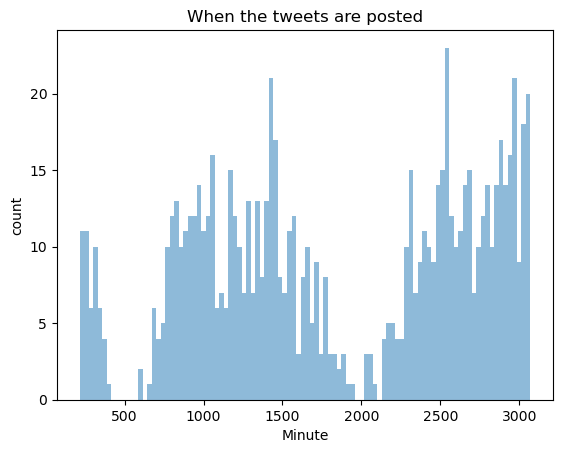

In [124]:
# Let's take a look at the temporal distributed with weather-related Tweets posted across time

plt.hist(sec, bins=100, alpha=0.5)
plt.title('When the tweets are posted')
plt.xlabel('Minute')
plt.ylabel('count')

plt.show()

<a id='aggregate'></a>

## 3. Aggregate the result to the census tract

The following cell will allow users to aggregate the human sentiments of heat exposure from each Tweets to the spaital domain in the city of Chicago.

Aggregate the result into census tract. [Inverse Distance Weighting (IDW)](https://en.wikipedia.org/wiki/Inverse_distance_weighting) is used when a census tract value is missinng.

In [50]:
d_final_census_track = {}

for i in range(0, 10):
    ## try 10 random time
    print("current "+str(i))

    ## Conduct kernel density estimation
    random_loc_twitter = generate_random_loc(weather_related_twitter)

    ### fill with inverse distance weighting


    for index, row in chicago.iterrows():
        key = index
        ele = row['geometry'] 
        lon = ele.centroid.x
        lat = ele.centroid.y
        ## iterate through all the values in the existing twitter
        up = 0
        down = 0
        IDW = 0
        for twitter in random_loc_twitter:
            pt = twitter[0]
            curr_x = pt.x
            curr_y = pt.y
            curr_val = twitter[1]

            distx = (curr_x-lon)*82
            disty = (curr_y-lat)*111

            w = 1/np.sqrt(distx*distx+disty*disty)

            down = down+w
            up = up+w*curr_val
        rt = up/down

        if (key not in d_final_census_track.keys()):
            d_final_census_track[index]=[rt]
        else:
            d_final_census_track[index].append(rt)

current 0
current 1
current 2
current 3
current 4
current 5
current 6
current 7
current 8
current 9


Calculate Normalized Human Sentiments of Heat Exposure

In [51]:
heat_exposure_map_census_track = {}
for key in d_final_census_track.keys():
    ## Get the average hot exposure
    heat_exposure_map_census_track[key] = np.mean(d_final_census_track[key])

In [52]:
## nomalization to 0-1
mn = min(heat_exposure_map_census_track.values())
mx = max(heat_exposure_map_census_track.values())
for key in heat_exposure_map_census_track.keys():
    norm = (heat_exposure_map_census_track[key]-mn)/(mx-mn)
    heat_exposure_map_census_track[key] = norm

In [53]:
chicago["he_val"]=list(heat_exposure_map_census_track.values())

Show the result geopandas dataframe for visualization

In [54]:
chicago

,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,notes,statefp10,tractce10,geometry,he_val
0,44,44.0,031,17031842400,8424,Census Tract 8424,None,17,842400,"POLYGON ((-87.62405 41.73022, -87.62405 41.730...",0.615173
1,59,59.0,031,17031840300,8403,Census Tract 8403,None,17,840300,"POLYGON ((-87.68608 41.82296, -87.68607 41.823...",0.000000
2,34,34.0,031,17031841100,8411,Census Tract 8411,None,17,841100,"POLYGON ((-87.62935 41.85280, -87.62934 41.852...",0.516141
3,31,31.0,031,17031841200,8412,Census Tract 8412,None,17,841200,"POLYGON ((-87.68813 41.85569, -87.68816 41.856...",0.629146
4,32,32.0,031,17031839000,8390,Census Tract 8390,None,17,839000,"POLYGON ((-87.63312 41.87449, -87.63306 41.874...",0.624970
...,...,...,...,...,...,...,...,...,...,...,...
796,7,7.0,031,17031070400,704,Census Tract 704,None,17,070400,"POLYGON ((-87.65746 41.93258, -87.65722 41.932...",0.524770
797,7,7.0,031,17031070500,705,Census Tract 705,None,17,070500,"POLYGON ((-87.66349 41.93036, -87.66350 41.930...",0.519039
798,13,13.0,031,17031130300,1303,Census Tract 1303,None,17,130300,"POLYGON ((-87.71436 41.98300, -87.71472 41.982...",0.635189
799,29,29.0,031,17031292200,2922,Census Tract 2922,None,17,292200,"POLYGON ((-87.71317 41.85523, -87.71357 41.855...",0.582664


<a id='map'></a>

## 4. Choropleth Map

The following cell will introduce Choropleth Map and show users with different methods for data classificaiton, including quantile, equal interval, and natural break.

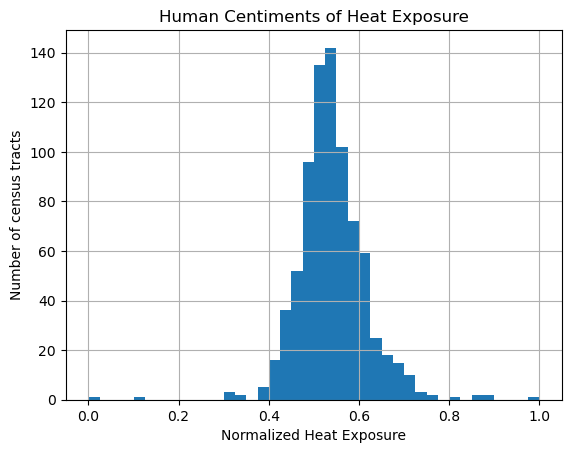

In [77]:
# Let's take a look at how the heat exposure variable is distributed with a histogram
chicago["he_val"].hist(bins=40)
plt.xlabel("Normalized Heat Exposure")
plt.ylabel("Number of census tracts")
plt.title("Human Centiments of Heat Exposure")
plt.show()

<Axes: >

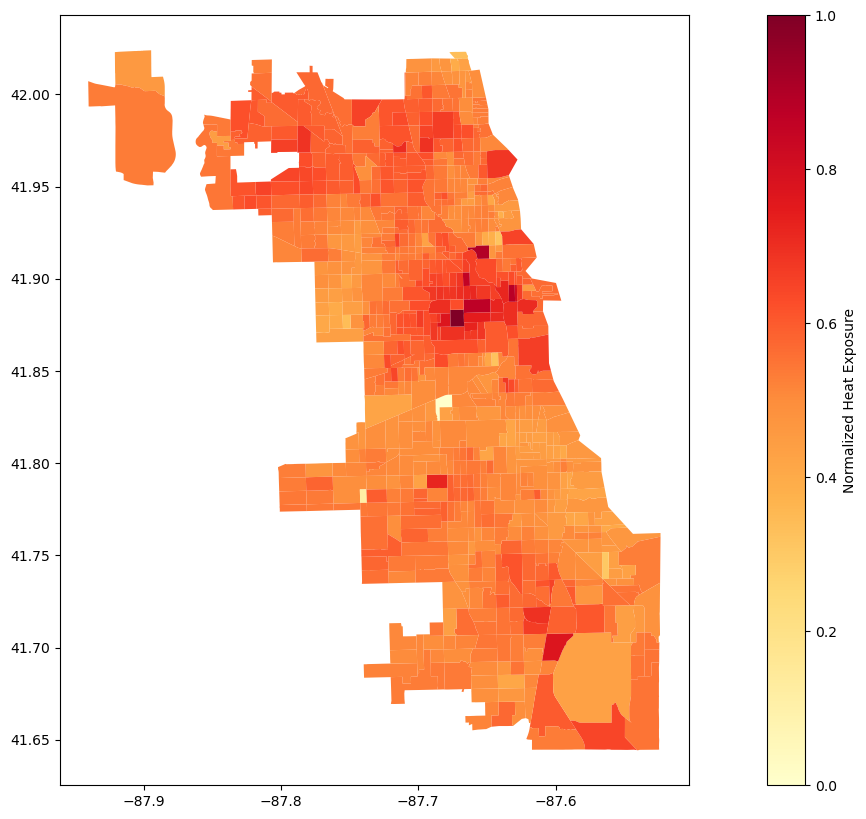

In [63]:
## Creating Choropleth Map with geopandas 
chicago.plot(column = 'he_val', #Assign numerical data column
                      legend = True, #Decide to show legend or not
                      figsize = [20,10],
                      cmap = 'YlOrRd',
                      legend_kwds = {'label': "Normalized Heat Exposure"}) #Name the legend

### Quantile Classification
Quantile classification is a method in GIS for dividing numerical data into classes with an equal number of values in each class. It is useful for creating choropleth maps that visually represent the distribution of data across geographic areas.

In [79]:
he_val= list(chicago['he_val'])

In [88]:
## Show the percentile value for 5 classes

print("The 20th percentile is " + str(np.percentile(he_val, 20)))
print("The 40th percentile is " + str(np.percentile(he_val, 40)))
print("The 60th percentile is " + str(np.percentile(he_val, 60)))
print("The 80th percentile is " + str(np.percentile(he_val, 80)))

The 20th percentile is 0.48696763527357756
The 40th percentile is 0.5191584842123932
The 60th percentile is 0.5483343741135247
The 80th percentile is 0.5936779025646657


<Axes: >

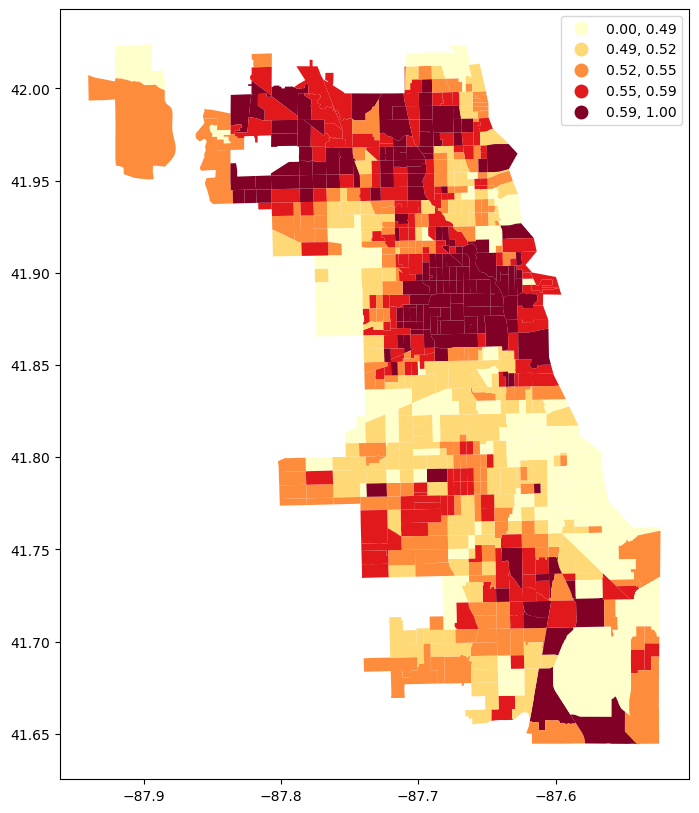

In [71]:
## Quantile Map
chicago.plot(column = 'he_val', #Assign numerical data column
                      scheme="quantiles", 
                      k=5,
                      legend = True, #Decide to show legend or not
                      figsize = [20,10],
                      cmap = 'YlOrRd') #Name the legend

### Equal Interval Classification
Equal interval classification is a method used in GIS to divide a range of numerical data into classes or intervals of equal size. In this method, the total range of the data (the difference between the maximum and minimum values) is divided into a specified number of equal-sized intervals or classes, with each class having the same width or size.

In [85]:
he_val= list(chicago['he_val'])
mn, mx = min(he_val), max(he_val)

In [87]:
mn,mx

(0.0, 1.0)

In [93]:
## Show the equal interval value for 5 class

print("The 1th value is " + str(1*(mx-mn)/5))
print("The 2nd value is " + str(2*(mx-mn)/5))
print("The 3rd value is " + str(3*(mx-mn)/5))
print("The 4th value is " + str(4*(mx-mn)/5))

The 1th value is 0.2
The 2nd value is 0.4
The 3rd value is 0.6
The 4th value is 0.8


<Axes: >

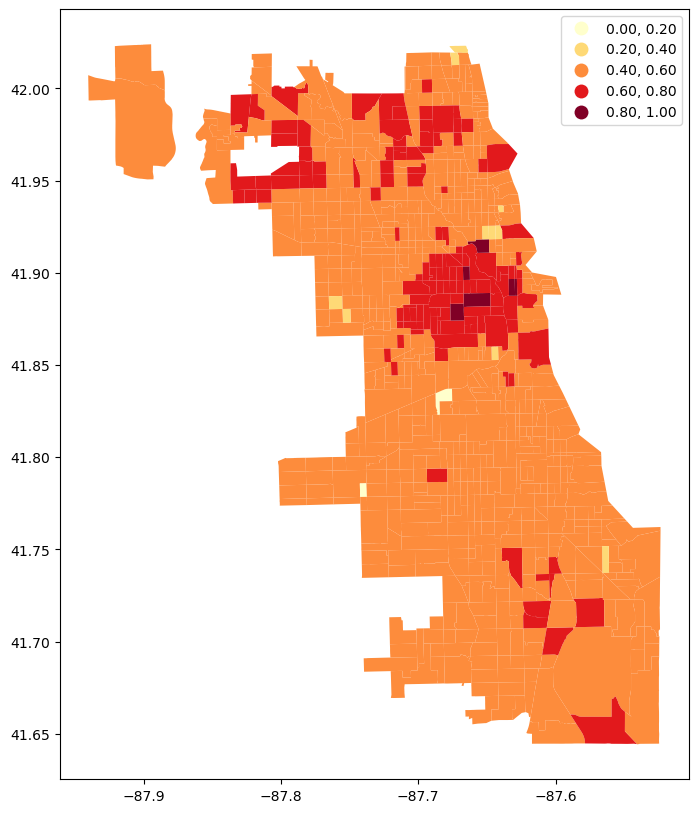

In [72]:
## Equal Interval
chicago.plot(column = 'he_val', #Assign numerical data column
                      scheme="equal_interval", 
                      k=5,
                      legend = True, #Decide to show legend or not
                      figsize = [20,10],
                      cmap = 'YlOrRd') #Name the legend

### Natural Break

Jenks natural breaks is a data classification method in GIS that determines the best arrangement of values into different classes by minimizing the variance within classes and maximizing the variance between classes. It aims to reveal natural groupings and patterns in the data.

In [96]:
!pip install jenkspy

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.0/622.0 kB 11.0 MB/s eta 0:00:00a 0:00:01


In [99]:
import jenkspy
he_val= list(chicago['he_val'])

[a0, a1, a2, a3, a4, a5] = jenkspy.jenks_breaks(he_val, n_classes=5)
print("The 1th value is " + str(a1))
print("The 2nd value is " + str(a2))
print("The 3rd value is " + str(a3))
print("The 4th value is " + str(a4))

The 1th value is 0.11072607704060058
The 2nd value is 0.4925205280373307
The 3rd value is 0.5651278201021268
The 4th value is 0.6605997264475872


<Axes: >

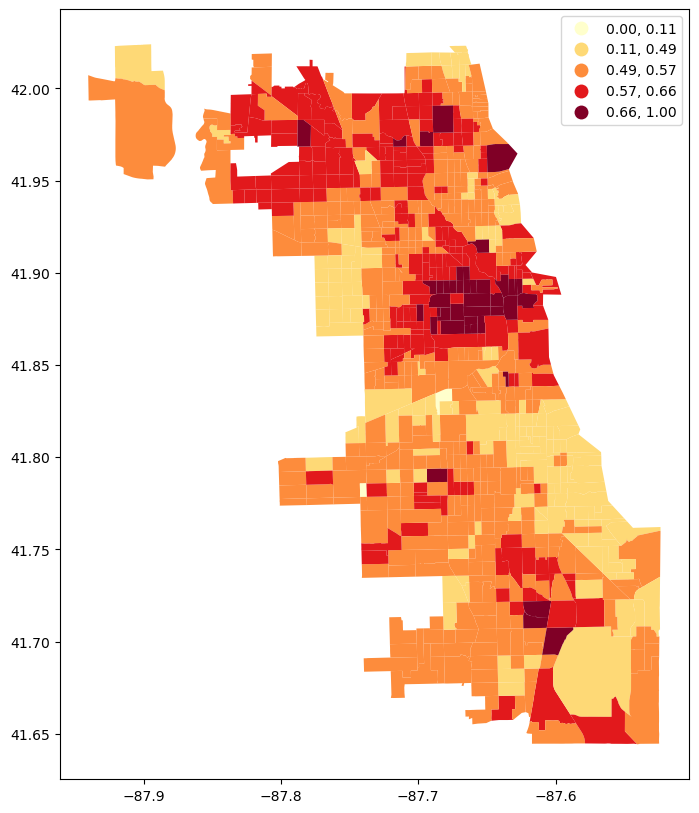

In [73]:
## Natural Break
chicago.plot(column = 'he_val', #Assign numerical data column
                      scheme="natural_breaks", 
                      k=5,
                      legend = True, #Decide to show legend or not
                      figsize = [20,10],
                      cmap = 'YlOrRd') #Name the legend